In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
from gtda.time_series import SlidingWindow
import matplotlib.pyplot as plt
from math import atan2, pi, sqrt, cos, sin, floor
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True  
config.log_device_placement = True  
sess2 = tf.compat.v1.Session(config=config)
set_session(sess2)  
from tensorflow.keras.layers import Dense, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import load_model
from tcn import TCN, tcn_full_summary
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from keras_flops import get_flops
import pickle
import csv
import random
import itertools
import math
import time
import sys
# sys.path.append('/home/sjrhee/sjrhee/neural_kf_0926/agrobot/Agrobot\ Dataset/')

from data_utils_0 import *
from traj_utils import *
from neural_ekf import *

Device mapping: no known devices.


## Import Dataset

In [8]:
window_size = 100
stride = 20

f = 'dataset0/'
X_train,Y_Pos_train, Physics_Vec_train, x_vel_train, y_vel_train, x0_list_train, y0_list_train, size_of_each_train = import_agrobot_dataset_p1(dataset_folder=f, type_flag=1, window_size=window_size, stride=stride)
P = np.repeat(Physics_Vec_train,window_size).reshape((Physics_Vec_train.shape[0],window_size,1))
X_train = np.concatenate((X_train,P),axis=2)

X_test,Y_Pos_test, Physics_Vec_test, x_vel_test, y_vel_test, x0_list_test, y0_list_test, size_of_each_test= import_agrobot_dataset_p1(type_flag = 2, dataset_folder=f,window_size=window_size, stride=stride)
P_test = np.repeat(Physics_Vec_test,window_size).reshape((Physics_Vec_test.shape[0],window_size,1))
X_test = np.concatenate((X_test,P_test),axis=2)

List of log files being imported:  ['Log1, 100.csv', 'Log2, 100.csv', 'Log3, 100.csv', 'Log4, 100.csv', 'Log6, 100.csv', 'Log7, 100.csv', 'Log9, 100.csv']


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


List of log files being imported:  ['Log5, 100.csv', 'Log8, 100.csv']


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


## Load the Pre-trained Model

In [13]:
model = load_model('/home/sjrhee/sjrhee/neural_kf_0926/agrobot/Neural Kalman IMU GNSS Fusion/PreTrained Models/Agrobot_First_TCN.hdf5', custom_objects={'TCN':TCN})

## Kalman Model

Seen Trajectory

In [14]:
ATE = []
RTE = []
for i in range(len(size_of_each_train)):

    fused_pos_x, fused_pos_y, GPS_x, GPS_y =  neural_ekf_gnss_imu(X_train, x_vel_train,y_vel_train, 
                size_of_each_train,
                x0_list_train, y0_list_train,i,window_size,stride,60*5,
                 model)
    act_x,act_y =  GT_pos_generator(x_vel_train, y_vel_train, size_of_each_train, 
                   x0_list_train, y0_list_train, window_size, stride,i)
    
    
        
    at, rt, at_all, rt_all = Cal_TE(act_x, act_y, fused_pos_x, fused_pos_y,
                                    sampling_rate=100,window_size=window_size,stride=stride)

    ATE.append(at)
    RTE.append(rt)
    print('ATE, RTE:',ATE[i],RTE[i])
    
print('Median ATE and RTE', np.median(ATE),np.median(RTE))
print('Mean ATE and RTE', np.mean(ATE),np.mean(RTE))
print('STD ATE and RTE', np.std(ATE),np.std(RTE))

100%|██████████| 6108/6108 [04:49<00:00, 21.13it/s]


ATE, RTE: 0.9717143001553343 0.11638907120924974


100%|██████████| 6299/6299 [04:58<00:00, 21.11it/s]


ATE, RTE: 1.153622348795712 0.11136165350417193


100%|██████████| 6209/6209 [04:54<00:00, 21.07it/s]


ATE, RTE: 0.7463451962664451 0.09165671397841481


100%|██████████| 6061/6061 [04:47<00:00, 21.08it/s]


ATE, RTE: 0.7120401965935541 0.11764814819632471


100%|██████████| 6658/6658 [05:16<00:00, 21.07it/s]


ATE, RTE: 1.0499800471133833 0.1764296736146042


100%|██████████| 6301/6301 [04:59<00:00, 21.03it/s]


ATE, RTE: 1.759658498102126 0.16974397800389107


100%|██████████| 52424/52424 [41:02<00:00, 21.29it/s]


ATE, RTE: 2.2545972773383856 0.16790394462580913
Median ATE and RTE 1.0499800471133833 0.11764814819632471
Mean ATE and RTE 1.2354225520521342 0.13587616901892366
STD ATE and RTE 0.5260755561907903 0.03181581599033191


Unseen Trajectory

In [15]:
ATE = []
RTE = []
for i in range(len(size_of_each_test)):

    fused_pos_x, fused_pos_y, GPS_x, GPS_y =  neural_ekf_gnss_imu(X_test, x_vel_test,y_vel_test, 
                size_of_each_test,
                x0_list_test, y0_list_test,i,window_size,stride,5,
                 model)
    act_x,act_y =  GT_pos_generator(x_vel_test, y_vel_test, size_of_each_test, 
                   x0_list_test, y0_list_test, window_size, stride,i)
    
    
        
    at, rt, at_all, rt_all = Cal_TE(act_x, act_y, fused_pos_x, fused_pos_y,
                                    sampling_rate=100,window_size=window_size,stride=stride)

    ATE.append(at)
    RTE.append(rt)
    print('ATE, RTE:',ATE[i],RTE[i])
    
print('Median ATE and RTE', np.median(ATE),np.median(RTE))
print('Mean ATE and RTE', np.mean(ATE),np.mean(RTE))
print('STD ATE and RTE', np.std(ATE),np.std(RTE))


100%|██████████| 6101/6101 [04:50<00:00, 20.98it/s]


ATE, RTE: 1.0531184318929943 0.9263909662352441


100%|██████████| 6198/6198 [04:54<00:00, 21.08it/s]

ATE, RTE: 5.6304278806363985 1.06828073369285
Median ATE and RTE 3.341773156264696 0.997335849964047
Mean ATE and RTE 3.341773156264696 0.997335849964047
STD ATE and RTE 2.288654724371702 0.07094488372880292


Plot

In [16]:
fused_pos_x, fused_pos_y, GPS_x, GPS_y =  neural_ekf_gnss_imu(X_train, x_vel_train,y_vel_train, 
            size_of_each_train,
            x0_list_train, y0_list_train,0,window_size,stride,5,
             model)
act_x,act_y =  GT_pos_generator(x_vel_train, y_vel_train, size_of_each_train, 
               x0_list_train, y0_list_train, window_size, stride,0)


100%|██████████| 6108/6108 [04:49<00:00, 21.12it/s]


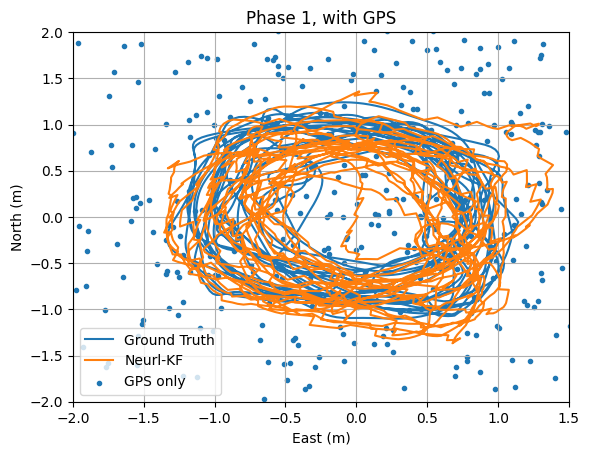

In [17]:
a = 0
b = 3000
plt.plot(act_x[a:b],act_y[a:b],label='Ground Truth',linestyle='-')
plt.plot(fused_pos_x[a:b],fused_pos_y[a:b],label='Neurl-KF',linestyle='-')
plt.scatter(GPS_x[math.ceil(a/5):math.ceil(b/5)],GPS_y[math.ceil(a/5):math.ceil(b/5)],
            marker='.',label='GPS only')
plt.xlim([-2,1.5])
plt.ylim([-2,2])
plt.grid('minor')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Phase 1, with GPS')
plt.legend(loc='best')